# Test Battery for Clique Detection

I'm here:
1. Extact loops from the pair
1. Fix the ```1AB 2AB 3AB --> 123 AB``` problem

In [1]:
# Parameters
# METHOD_ID="2020-01-20 partial pairs"
# METHOD_ID="2020-01-24 all pairs"
METHOD_ID="2020-01-25 untangled"

In [2]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="INFO"

import math
import logging
import sys
import networkx as nx
# import scipy
import matplotlib.pyplot as plt

# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO, stream=sys.stdout)

In [23]:
def find_loops_in_path(p, succ_G):
    """
    With all pairs, if ABC is a loop in pairs of len L then 
    f(A,B) = f(B,C) = L(L+1)/2 and f(B,A) = f(C,B) = L(L-1)/2
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    is_a_loop, L = False, 0

    # Check if p is a loop
    for a, b in [ (a,b) for a,b in zip( p[:-1], p[1:] )  ]:

        is_a_loop = True
        if is_a_loop and (b, a) in succ_G.edges():
            Wab = succ_G[a][b]['weight'] # also, Wab=f by construction
            Wba = succ_G[b][a]['weight']
            
            # Combinatory test:
            L = int( math.sqrt(Wab) ) + 1
            Lp1, Lm1 = L*(L+1)/2.0, L*(L-1)/2.0

            logger.debug( (a, b, Wab, Lp1, Wba, Lm1, L ))
            
            # Me falta chequear que L+1 y L-1 sean consistentes en todfo el path
            if Wab != Lp1 or Wba != Lm1:
                is_a_loop = False
        else:
            is_a_loop = False     
    return is_a_loop, L

In [32]:
def evaluate_against (T, expected_paths):
    logger = logging.getLogger( sys._getframe().f_code.co_name )

    G, paths = False, False
    
    if   METHOD_ID=="2020-01-24 all pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-24 all pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-20 partial pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-20 partial pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-25 untangled":
        
        # Remove the loops in each trace, and
        # also collect all successor pairs in a single variable.
        
        all_successors_combined = {}

        for trace in T[0:1]:
            succ_f = get_successor_by_freq([trace], METHOD_ID=METHOD_ID)
#             print(succ_f)
            succ_G = successorsGraph( succ_f )

            # Step 1: Detect loops based on raw paths
            paths = infer_paths( split_in_freqGraph(  succ_G  ) )

            remove_f_pats = {}
            for f, paths_f in paths.items():
                
                for p in paths_f:
                    is_a_loop, L = find_loops_in_path(p, succ_G)

                    if is_a_loop:
                        logger.info("Loop FOUND: repeated %d times in this trace, loop: %s" % (L, p) )
                        
                        # Go backwards
                        f_loop = L*(L-1)/2.0
                        if f_loop not in succ_f.keys(): 
                            raise ValueError("Hey!!! %d should be part of %s keys of succ_f !" % (f_loop, succ_f.keys()) )
                        # Then remove the back edges
                    else:
                        logger.debug("Is %s a loop? %s" % (p, is_a_loop))
    

        
#         G_aux = created_auxiliary_graph( paths )
#         G = minimally_connected(G_aux)
        
#         G_freq = split_in_freqGraph(G)
#         for f, g1 in G_freq.items():
#             graph(g1, with_weigths=True)
            
#         graph(G)

#         paths = { 1:[] }
# #         for f, G1 in G_freq.items():
# #             paths[f] = nx.all_shortest_paths(G, "_START_", "_END_")
            
#         for path in nx.all_simple_paths(G, "_START_", "_END_"):
#             path.remove("_START_")
#             path.remove("_END_")
#             paths[1].append( path )
        

    else:
        raise ValueError("Not valid METHOD_ID")
             
            
    if paths:
        
        G = nx.DiGraph()
        for f, path in paths.items():
            for a, b in [ (a,b) for t in path for a,b in zip( t[:-1], t[1:] )  ]:
                G.add_edge( a, b, weight=f)
        graph(G, with_weigths=True )
        
        good = []
        bad = []
        expected = [ list(a) for a in expected_paths ]
        for f, paths in paths.items():
            for p in paths:
    #             print(paths)
                if p in expected:
                    good.append( "%d: %s" % (f, "".join(p)) )
                else:
                    bad.append( "%d: %s" % (f, "".join(p)) )

        if len(expected_paths) != len(good):
            print(), print()
            print("WARNING HERE! OJO AQUI!")
            print(), print()
        print("These %s paths were correctly detected (%s undetected):" % (len(good), len(expected_paths)-len(good)))
        print(good)
        print()

        print("These %s paths are spurious:" % len(bad))
        print (bad)
        return good, bad
    else:
        return [], []

In [4]:
def created_auxiliary_graph( weighted_paths ):
    
    def append_path(G, path, weight):
        edges = []
        previous = path[0]
        for node in path[1:]:
            edges.append( (previous, node, {"weight": round(weight, 2)} ) )
            previous = node
        G.add_edges_from(edges)

    G = nx.DiGraph()
    for w in sorted(weighted_paths, reverse=True):
        for path_w in weighted_paths[w]:
            append_path( G, path_w, w )            
    return G

In [5]:
#2020-01-25
# If paths (u,z,v) and (u,v) exists, leave just (u,z,v)
def minimally_connected(G):
    G_minimal = G.copy()
    
    for u, v in G.edges():

        # u has already v, then I will work if I have more than one neighbor
        if len(G[u]) > 1:
            remove_edge = False
            # look if I have a longest u,z,v path
            for z, attr in G[u].items():
                if z != v and z != u:
                    if nx.has_path(G_minimal, z, v):
                        remove_edge = True
            if remove_edge:
                G_minimal.remove_edge( u, v )    
    return G_minimal

In [6]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [7]:
def get_successor_by_freq( traces, METHOD_ID="2020-01-24 all pairs" ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)
    
    pairs_with_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace, METHOD_ID=METHOD_ID):
            if pair in pairs_with_freq.keys():
                pairs_with_freq[pair] = pairs_with_freq[pair] + 1.0/L
            else:
                pairs_with_freq[pair] = 1.0/L
            
    By_freq = {}
    for (u, v), freq in pairs_with_freq.items():
        f = round(freq,3)
        if f in By_freq.keys():
            By_freq[f].append( (u,v) )
        else:
            By_freq[f] =[ (u,v) ]
    logger.debug("Freq  pairs using method=%s : %s" % (METHOD_ID, By_freq) )
    return By_freq

In [8]:
def successorsGraph(successor_by_freq):
    G=nx.DiGraph()
    for f, pairs in successor_by_freq.items():
        for u, v in pairs:
            G.add_edge(u, v, weight=f)
            
    return G

In [29]:
# Sort the cliques and apply the rules:
# 1) The nodes of a single path in their equivalent pair has in_degree=0,1,2,...
# 2) A path is composed for at least 2 nodes

def infer_paths(G_freq, min_clique_size=2):
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.debug("Received a dict G with f=%s" % G_freq.keys())

    paths_f = {}
    cliques_f = { f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }
    logger.debug("All cliques are %s" % cliques_f)
        
    for f, cliques in cliques_f.items():
#         logger.debug("Clique[%d] = %s" % (f, cliques) )
        paths = []
        for clique in cliques:
            logger.debug("F=%d, clique=%s" % (f, clique))
    
            # From the original graph(f),
            G_complete = G_freq[f].copy()
            
            # remove the nodes not in this clique 
            for node in set(G_complete.nodes).difference( set(clique) ):
                G_complete.remove_node(node)
                
            # Order nodes by inner degree
            nodes = sorted( G_complete.in_degree() , key=lambda p: p[1], reverse=False)
            logger.debug("Nodes: %s" %  nodes)

            # - core - CRITERIA 1 and 2
            # Strict checking: in_degree(n) in [0, ... , len(N)-1]
            if len(nodes) >=min_clique_size and ( 
                all( [in_degree == i for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
                or
                all( [in_degree == i+1 for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
            ):
                    paths.append ( [ a for a, in_degree in nodes ] )
            else:
                logger.debug("This clique doesn't match the in_degree critera")
        if paths:
            paths_f[f] = paths

    logger.info("Paths inferred (min_clique_size=%d: %s)" % (min_clique_size, paths_f) )
    return paths_f

In [10]:
# Including Modifications by Andres (20200124)
ADD_START_END = False
def get_successor_pairs( T_prime , ADD_START_END=ADD_START_END, METHOD_ID="2020-01-24 all pairs"):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j
    
    ADDED 2020-01-23:
    Que no se repitan!

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """

    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)


    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
        if METHOD_ID == "2020-01-20 partial pairs":
#         if METHOD_ID != "2020-01-24 all pairs":
            T_i_j=partial_subtrace[:j] # 2020-01-20 Old BEHAVIOR
        else:
            T_i_j=partial_subtrace[:] # Andres 20200124 .. all friends with all, including loops
        
        T_i_j_pairs = [] # 2020-01-23 BEHAVIOR ... but not remove, it doesn't affect

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)

            pairs.append(e)       # 2020-01-20 Old BEHAVIOR
            
#             if e not in T_i_j_pairs:  # 2020-01-23 BEHAVIOR
#                 T_i_j_pairs.append(e) # 2020-01-23 BEHAVIOR
#         pairs += T_i_j_pairs          # 2020-01-23 BEHAVIOR
            
            
            # Added 2020-01-18: global star / end
            if ADD_START_END:
                pairs.append( ("_START_", s_i) )
                pairs.append(( s_k, "_END_") )

    logger.debug("Found pairs using method=%s : %s" % (METHOD_ID, pairs) )
    return pairs

In [11]:
def split_in_freqGraph( successorsGraph ):
    
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    u_v_f = [ (u, v, successorsGraph[u][v]["weight"]) for u, v in successorsGraph.edges]
    frqs = set([ f for u, v, f in u_v_f])
    logger.debug("freqs found: %s" % frqs)
    G={}
    for f in frqs:
        G[f] = successorsGraph.copy()
        # Get all nodes whose pairs has weight!=f
        for u, v, f2 in u_v_f:
            if f != f2:
                G[f].remove_edge(u,v)
        logger.debug("Nodes in freq=%d: %s" % (f, G[f].nodes) )
        
    logger.debug("About to return a set of G with f=%s" % G.keys())
    return G

## Tested examples

### Simple Loop Examples

INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Paths inferred (min_clique_size=2: {10.0: [['A', 'B', 'C']], 6.0: [['C', 'B', 'A']]})
INFO:Loop FOUND: repeated 4 times in this trace, loop: ['A', 'B', 'C']


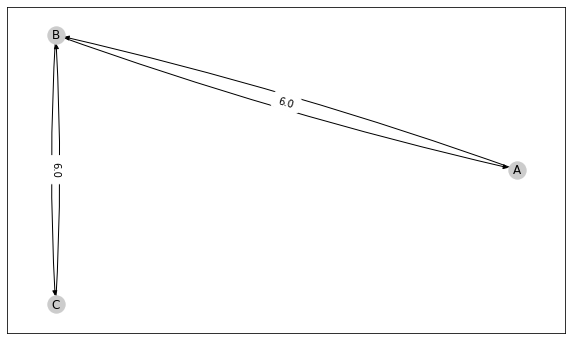

These 1 paths were correctly detected (0 undetected):
['10: ABC']

These 1 paths are spurious:
['6: CBA']


In [33]:
T = [
    list("ABCABCABCABC"),
]
g, b = evaluate_against(T, ["ABC"] )

INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Using METHOD_ID 2020-01-25 untangled
{3.0: [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')], 1.0: [('A', 'A'), ('B', 'A'), ('B', 'B'), ('C', 'A'), ('C', 'B'), ('C', 'C'), ('D', 'A'), ('D', 'B'), ('D', 'C'), ('D', 'D')]}
INFO:F=1, clique=['D', 'B', 'C', 'A']
INFO:F=3, clique=['D', 'B', 'C', 'A']
INFO:Paths inferred (min_clique_size=2: {1.0: [['D', 'C', 'B', 'A']], 3.0: [['A', 'B', 'C', 'D']]})
INFO:Loop FOUND: repeated 2 times in this trace, loop: ['A', 'B', 'C', 'D']


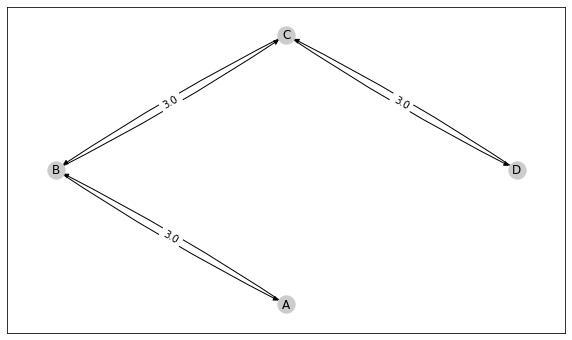

These 1 paths were correctly detected (0 undetected):
['3: ABCD']

These 1 paths are spurious:
['1: DCBA']


In [21]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

In [ ]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

### Complex Loop Examples

In [ ]:
# Type 75
T = [
    list("ABC1231A2B3C1ABC23zxcv"),
]
g, b = evaluate_against(T, ("ABC", "123", "zxcv") )

INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Using METHOD_ID 2020-01-25 untangled
{6.0: [('A', 'B'), ('A', 'C'), ('B', 'C'), ('1', '1'), ('2', '1'), ('2', '2'), ('3', '1'), ('3', '2'), ('3', '3')], 3.0: [('A', 'A'), ('B', 'A'), ('B', 'B'), ('C', 'A'), ('C', 'B'), ('C', 'C')], 12.0: [('A', '1'), ('A', '2'), ('A', '3'), ('B', '1'), ('B', '2'), ('B', '3'), ('C', '1'), ('C', '2'), ('C', '3')], 10.0: [('1', '2'), ('1', '3'), ('2', '3')]}
INFO:F=10, clique=['2', '1', '3']
INFO:F=10, clique=['B']
INFO:This clique doesn't match the in_degree critera
INFO:F=10, clique=['C']
INFO:This clique doesn't match the in_degree critera
INFO:F=10, clique=['A']
INFO:This clique doesn't match the in_degree critera
INFO:F=3, clique=['1']
INFO:This clique doesn't match the in_degree critera
INFO:F=3, clique=['2']
INFO:This clique doesn't match the in_degree critera
INFO:F=3, clique=['3']
INFO:This clique doesn't match the in_degree critera
INFO:F=3, clique=['B', 'C', 'A']
INFO:F=12, clique=['B', '1']
INFO:F

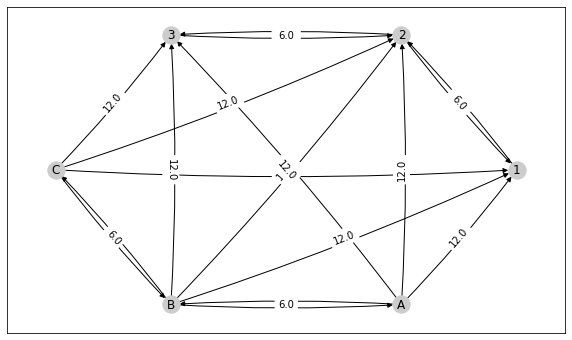

These 2 paths were correctly detected (0 undetected):
['10: 123', '6: ABC']

These 11 paths are spurious:
['3: CBA', '12: B1', '12: B3', '12: B2', '12: C1', '12: C3', '12: C2', '12: A1', '12: A3', '12: A2', '6: 321']


In [24]:
# Type 76
T = [
    list("ABCABCABC123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

In [ ]:
# Type 76-b
T = [
    list("ABCABCABC"),
    list("123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Paths inferred (min_clique_size=2: {1.0: [['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']], 2.0: [['2', 'p'], ['2', 's'], ['e', '2'], ['2', 'o'], ['d', '2'], ['f', '2'], ['2', 'l'], ['j', '2'], ['2', 'u'], ['c', '2'], ['2', 'n'], ['2', 'q'], ['2', 'r'], ['i', '2'], ['2', 'm'], ['2', 't'], ['k', '2'], ['h', '2'], ['g', '2'], ['B', 'p'], ['B', 's'], ['e', 'B'], ['B', 'o'], ['d', 'B'], ['f', 'B'], ['B', 'l'], ['j', 'B'], ['B', 'u'], ['c', 'B'], ['B', 'n'], ['B', 'q'], ['B', 'r'], ['i', 'B'], ['B', 'm'], ['B', 't'], ['k', 'B'], ['h', 'B'], ['g', 'B'], ['m', 'C'], ['n', 'C'], ['p', 'C'], ['j', 'C'], ['q', 'C'], ['C', 'u'], ['C', 't'], ['k', 'C'], ['i', 'C'], ['C', 's'], ['e', 'C'], ['o', 'C'], ['C', 'r'], ['h', 'C'], ['g', 'C'], ['f', 'C'], ['l', 'C'], ['1', 'm'], ['1', 'n'], ['1', 'p'], ['1', 'j'], ['1', 'q'], ['1', 't']

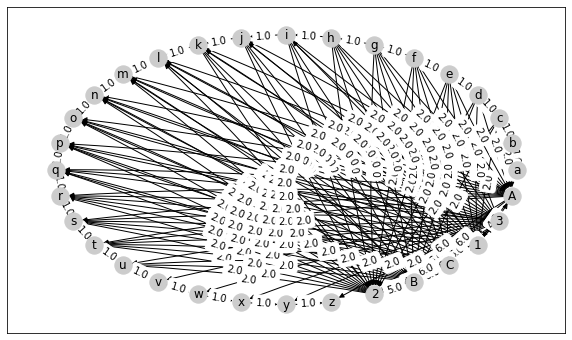

These 3 paths were correctly detected (0 undetected):
['1: abcdefghijklmnopqrstuvwxyz', '6: 123', '6: ABC']

These 126 paths are spurious:
['2: 2p', '2: 2s', '2: e2', '2: 2o', '2: d2', '2: f2', '2: 2l', '2: j2', '2: 2u', '2: c2', '2: 2n', '2: 2q', '2: 2r', '2: i2', '2: 2m', '2: 2t', '2: k2', '2: h2', '2: g2', '2: Bp', '2: Bs', '2: eB', '2: Bo', '2: dB', '2: fB', '2: Bl', '2: jB', '2: Bu', '2: cB', '2: Bn', '2: Bq', '2: Br', '2: iB', '2: Bm', '2: Bt', '2: kB', '2: hB', '2: gB', '2: mC', '2: nC', '2: pC', '2: jC', '2: qC', '2: Cu', '2: Ct', '2: kC', '2: iC', '2: Cs', '2: eC', '2: oC', '2: Cr', '2: hC', '2: gC', '2: fC', '2: lC', '2: 1m', '2: 1n', '2: 1p', '2: 1j', '2: 1q', '2: 1t', '2: 1k', '2: 1i', '2: 1s', '2: e1', '2: 1o', '2: d1', '2: 1r', '2: c1', '2: g1', '2: h1', '2: 1l', '2: f1', '2: p3', '2: 3s', '2: e3', '2: o3', '2: 3v', '2: l3', '2: f3', '2: j3', '2: 3u', '2: 3w', '2: n3', '2: 3x', '2: 3q', '2: 3z', '2: 3r', '2: i3', '2: m3', '2: 3t', '2: k3', '2: h3', '2: g3', '2: 3y', '2: d

In [34]:
# Type 77
T = [
    list("aAb1B2cd3Cefgh1iAjk2Blmnop3qCrst1AuBC2vwxyz3"),
]
g, b = evaluate_against(T, ("ABC", "123", "abcdefghijklmnopqrstuvwxyz") )

INFO:Using METHOD_ID 2020-01-25 untangled
INFO:Using METHOD_ID 2020-01-25 untangled
{9.0: [('.', '1')], 14.0: [('.', 'A'), ('2', '.')], 78.0: [('.', '.')], 17.0: [('.', 'B'), ('1', '.')], 12.0: [('.', '2')], 20.0: [('.', 'C')], 15.0: [('.', '3')], 3.0: [('1', 'A'), ('1', '2'), ('1', '3'), ('A', 'A'), ('A', '1'), ('B', '2'), ('B', 'A'), ('B', 'B'), ('2', '3'), ('2', 'B'), ('C', '3'), ('C', 'A'), ('C', 'B'), ('C', 'C'), ('3', 'C')], 4.0: [('1', 'B'), ('1', 'C'), ('A', '2'), ('A', '3'), ('B', '3'), ('2', 'C')], 1.0: [('1', '1'), ('2', '1'), ('2', '2'), ('3', '1'), ('3', '2'), ('3', '3')], 25.0: [('A', '.')], 6.0: [('A', 'B'), ('A', 'C'), ('B', 'C')], 22.0: [('B', '.')], 2.0: [('B', '1'), ('2', 'A'), ('C', '1'), ('C', '2'), ('3', 'A'), ('3', 'B')], 19.0: [('C', '.')], 11.0: [('3', '.')]}
INFO:All cliques are {1.0: [['2', '1', '3'], ['B'], ['C'], ['.'], ['A']], 2.0: [['2', 'C'], ['2', 'A'], ['B', '1'], ['B', '3'], ['1', 'C'], ['3', 'A'], ['.']], 3.0: [['.'], ['2', '1', '3'], ['2', 'B'], ['C

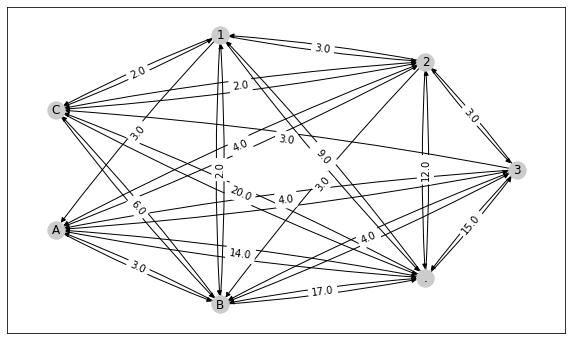

These 2 paths were correctly detected (0 undetected):
['3: 123', '6: ABC']

These 29 paths are spurious:
['1: 321', '2: C2', '2: 2A', '2: B1', '2: 3B', '2: C1', '2: 3A', '3: 2B', '3: 3C', '3: CBA', '3: 1A', '4: 2C', '4: A2', '4: 1B', '4: B3', '4: 1C', '4: A3', '9: .1', '11: 3.', '12: .2', '14: 2.', '14: .A', '15: .3', '17: 1.', '17: .B', '19: C.', '20: .C', '22: B.', '25: A.']


In [28]:
# Type 78
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.")
]
g, b = evaluate_against(T, ("ABC", "123") )

Claim: all paths (cliques) forming a base are loops. Starting from max(f) -> min(f).

### Examples from previous notebooks

In [ ]:
# combined_loops: lk 12 ABCDE
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ("ABCDE", "lk", "12") )

In [ ]:
"""
head_with_loop = 12 ABCD* ef*

12 @ABCD @ef
"""
T = [
    list("12ABCDefABCDABCDef"),
]
g, b = evaluate_against(T, ("ABCD", "12", "ef") )

In [ ]:
"""
  @lk - @12 - @ABCDE
"""
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ["ABCDE", "lk", "12"] )

In [ ]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
g, b = evaluate_against(T, ("ABC", "123") )

## Still Failing. Still...

In [ ]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )

In [ ]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )

In [ ]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345FG", "hjk", "def", "xyz"] )

In [ ]:
tree_trace = [
    list("ABmn12"),
    list("ABmn56"),
    list("ABpq12"),
    list("ABpq56"),
    list("ABst12"),
    list("ABst56"),
]
# inferred_paths = clique_discovery.infer_paths_from_traces( tree_trace )
# untangled_graph( clique_discovery.minimally_connected_graph( inferred_paths ) , with_weigths=False )
g, b = evaluate_against(tree_trace, ["AB", "mn", "12", "pq", "st", "56"] )